In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA, IncrementalPCA

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [3]:
digits_data = pd.read_csv('mnist_train.csv')
#digits_data = digits_data.sample(frac=0.4)
digits_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
digits_data.shape

(60000, 785)

#### Checking class distribution of digits

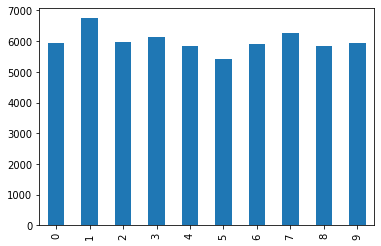

In [62]:
digits_data.label.value_counts().sort_index().plot.bar()

In [10]:
scaler = MinMaxScaler()

In [6]:
X_train = digits_data.drop('label',axis=1)
y_train = digits_data.label

In [11]:
X_train_std = scaler.fit_transform(X_train)

Scaling pixel grayscale values.

In [66]:
digits_test = pd.read_csv('mnist_test.csv')
X_test = digits_test.drop('label',axis=1)
y_test = digits_test.label
X_test_std = scaler.transform(X_test)

In [67]:
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


60000 training rows and 10000 testing rows

In [12]:
simple_model = SVC(C=10,random_state=19)
simple_model.fit(X_train,y_train)
y_train_pred = simple_model.predict(X_train)

print(accuracy_score(y_train,y_train_pred))

C:\Users\jatin.bhola\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9994047619047619


Very good accuracy achieved on training data. Lets see on test data as well

In [13]:
y_pred = simple_model.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.9579166666666666


Good accuracy achieved on testing data as well.

In [15]:
svc = SVC(C=10)
k=3
params={
    'gamma':[1e-5,1e-4,1e-3,1e-2,1e-1,1]
}
model_cv = GridSearchCV(estimator=svc,
                        param_grid=params,
                        cv=k,
                        scoring='accuracy',
                        return_train_score=True, 
                        verbose=1, 
                        n_jobs=-1)
model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 25.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [16]:
cv_results = model_cv.cv_results_

print(model_cv.best_params_)

{'gamma': 0.001}


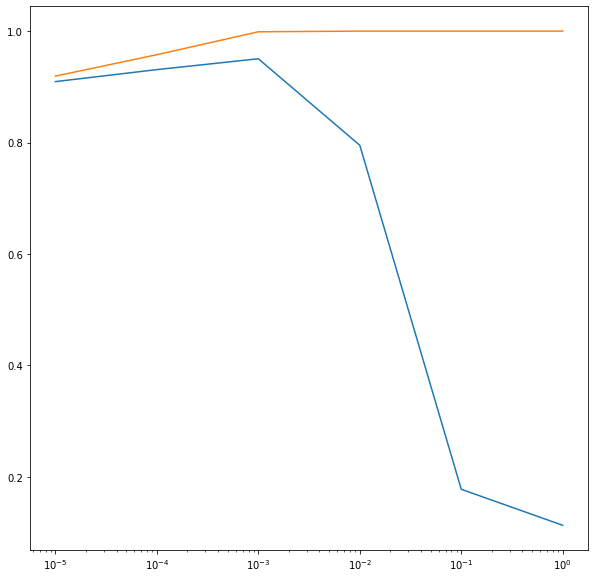

In [19]:
plt.figure(figsize=(10,10))
plt.plot(cv_results['param_gamma'],cv_results["mean_test_score"])
plt.plot(cv_results['param_gamma'],cv_results["mean_train_score"])
plt.xscale('log')

In [23]:
digit_full = pd.read_csv('mnist_train.csv')
X = digit_full.drop('label',axis=1)
y = digit_full.label
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.7,random_state=100)
final_model = SVC(C=10,gamma=1e-3)
final_model.fit(X_train,y_train)
print(final_model.score(X_train,y_train))
print(final_model.score(X_test,y_test))

0.9983095238095238
0.9686111111111111


In [24]:
y_pred = final_model.predict(X_test)
print('accuracy',metrics.accuracy_score(y_test,y_pred))

accuracy 0.9686111111111111


#### Slightly better performance achieved by hyperparameter tuning SVC. Trying effect of PCA on final model

In [12]:
pca =PCA()
pca.fit(X_train_std)

PCA()

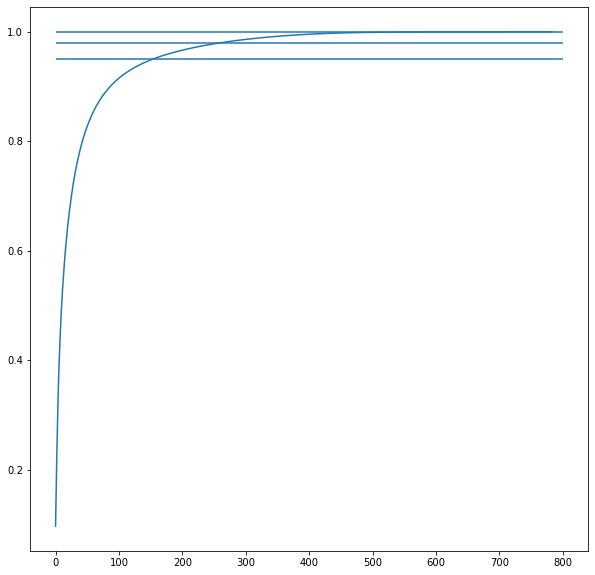

In [13]:
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,10))
plt.plot(cum_ratio)
plt.hlines(0.95,0,800)
plt.hlines(0.98,0,800)
plt.hlines(1,0,800)

#### Taking components covering 98% of information from original features. Number of components is reduced to mid-200s from 784

In [70]:
pca = PCA(0.98)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
final_model = SVC(C=10,gamma=1e-3)
final_model.fit(X_train_pca,y_train)
print(final_model.score(X_train_pca,y_train))
print(final_model.score(X_test_pca,y_test))

0.99755
0.9735


#### Using PCA slightly improved testing accuracy and reduced overfitting. Final test accuracy of 97.3% was achieved.

In [72]:
submission_X = pd.read_csv('test.csv')
sub_std = scaler.transform(submission_X)
sub_pca = pca.transform(sub_std)
submission_Y = final_model.predict(sub_pca)

In [73]:
pd.Series(submission_Y,index=np.arange(1,submission_Y.shape[0]+1)).to_csv('newsubmission.csv',header='label',index_label='ImageId')

In [75]:
pd.DataFrame({"ImageID":range(1,submission_Y.shape[0]+1),"Label":submission_Y}).to_csv('newsubmission.csv',index=False)